In [54]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [55]:
# function to load dataset and apply longitude correction; returns dataset for first time slice
def load_ds(fp, time=True):
    # open dataset and apply longitude correction 
    ds = xr.open_dataset(fp)
    lon_enc = ds["lon"].encoding
    lon_attrs = ds["lon"].attrs
    # subtract from 0-360 lon coords to get -180 to 180 lon coords, and reapply encoding
    ds.coords["lon"] = (ds.coords["lon"] + 180) % 360 - 180
    ds["lon"].encoding = lon_enc
    ds["lon"].attrs = lon_attrs
    # sort
    ds = ds.sortby(ds.lon, ascending=True)
    if time==True:
        # get first time slice
        ds = ds.isel(time=[0])
    else:
        pass
    return ds


# function to plot target, target mask, source, source mask, and regridded datasets side by side
def regrid_plots(target_ds, src_ds, regrid_ds, threshold, var_id, lat_slice, lon_slice):
    fig, ax = plt.subplots(1, 4, figsize=(25, 4))
    vmin, vmax = src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).min(), src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).max()

    target_ds['mask'].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[0])
    src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[1], vmin=vmin, vmax=vmax)
    src_ds['mask'].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[2])    
    regrid_ds[var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[3], vmin=vmin, vmax=vmax)

    ax[0].set_title(f"target land mask > {threshold}")
    ax[1].set_title(f"{var_id} source data")
    ax[2].set_title(f"source land mask > {threshold}")
    ax[3].set_title(f"{var_id} regridded data")

    for a in range(len(ax)):
        ax[a].set_xlabel("")
        ax[a].set_ylabel("")

    plt.show()


# function to mask, regrid with model-specific mask, and plot
def regrid_landmask_and_plot(target_ds, target_land_mask, src_ds, src_land_mask, threshold, var_id, lat_slice, lon_slice):
    # regrid the model's land mask to the model's source data (just in case there are discrepancies)
    target_regridder = xe.Regridder(target_land_mask, target_ds, "bilinear", unmapped_to_nan=True)
    target_land_mask_regrid = target_regridder(target_land_mask, keep_attrs=True)

    src_regridder = xe.Regridder(src_land_mask, src_ds, "bilinear", unmapped_to_nan=True)
    src_land_mask_regrid = src_regridder(src_land_mask, keep_attrs=True)
    
    # use land area percentage threshold to create the mask variable in both target and source datasets
    src_ds["mask"] = xr.where((src_land_mask_regrid["sftlf"]>threshold), 1, 0)
    target_ds["mask"] = xr.where((target_land_mask_regrid["sftlf"]>threshold), 1, 0)

    # regrid source to target, using extrapolation to fill inland NaNs;
    # regridder will recognize mask variables and act on the accordingly
    regridder = xe.Regridder(src_ds, target_ds, "bilinear", extrap_method="nearest_s2d")
    regrid_ds = regridder(src_ds, keep_attrs=True)

    # plot results
    regrid_plots(target_ds, src_ds, regrid_ds, threshold, var_id, lat_slice, lon_slice)


# function to mask, regrid with model-specific mask, and plot
def plot_data_and_land_masks(target_ds, target_land_mask, src_ds, src_land_mask, threshold, var_id, lat_slice, lon_slice):

    fig, ax = plt.subplots(1, 6, figsize=(25, 4))
    vmin, vmax = src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).min(), src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).max()

    target_ds[var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[0], vmin=vmin, vmax=vmax)
    target_land_mask['sftlf'].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[1])
    xr.where(target_land_mask['sftlf']>threshold, 1, 0).sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[2])
    src_ds[var_id].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[3], vmin=vmin, vmax=vmax)
    src_land_mask['sftlf'].sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[4])
    xr.where(src_land_mask['sftlf']>threshold, 1, 0).sel(lat=lat_slice, lon=lon_slice).plot(ax=ax[5])

    ax[0].set_title(f"{var_id} target data")
    ax[1].set_title("target land mask")
    ax[2].set_title(f"target land mask > {threshold}")
    ax[3].set_title(f"{var_id} source data")
    ax[4].set_title("source land mask")
    ax[5].set_title(f"source land mask > {threshold}")

    for a in range(len(ax)):
        ax[a].set_xlabel("")
        ax[a].set_ylabel("")

    plt.show()

In [56]:
# define coastal area used in plotting
lat_slice = slice(50, 65)
lon_slice = slice(-150, -135)

In [57]:
# dicts of model name, demo land only "mrro" source file to regrid, and "sftlf" land area fraction file to use as source mask
# these files were picked from the list generated here, which is missing some models:
# cmip6_dir = Path('/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/')
# fx_fps = list(cmip6_dir.glob("**/sftlf/**/*.nc"))
# for fp in fx_fps: print(fp)

model_mrro_landmask_dict = {
'CESM2-WACCM':{
    "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/mrro/gn/v20200702/mrro_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
    "sftlf":'/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r1i1p1f1/fx/sftlf/gn/v20190815/sftlf_fx_CESM2-WACCM_ssp370_r1i1p1f1_gn.nc',
},  
'GFDL-ESM4':{
    "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp245/r1i1p1f1/day/mrro/gr1/v20180701/mrro_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20550101-20741231.nc',
    "sftlf":'/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp370/r1i1p1f1/fx/sftlf/gr1/v20180701/sftlf_fx_GFDL-ESM4_ssp370_r1i1p1f1_gr1.nc',
},  
'TaiESM1':{
    "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/ssp126/r1i1p1f1/Lmon/mrro/gn/v20201124/mrro_Lmon_TaiESM1_ssp126_r1i1p1f1_gn_201501-210012.nc',
    "sftlf":'/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/ScenarioMIP/AS-RCEC/TaiESM1/ssp585/r1i1p1f1/fx/sftlf/gn/v20200901/sftlf_fx_TaiESM1_ssp585_r1i1p1f1_gn.nc',
},
'NorESM2-MM':{
    "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ssp126/r1i1p1f1/Lmon/mrro/gn/v20191108/mrro_Lmon_NorESM2-MM_ssp126_r1i1p1f1_gn_201502-202012.nc',
    "sftlf":'/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/ScenarioMIP/NCC/NorESM2-MM/ssp126/r1i1p1f1/fx/sftlf/gn/v20191108/sftlf_fx_NorESM2-MM_ssp126_r1i1p1f1_gn.nc',
},
'CNRM-CM6-1-HR':{
    "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1-HR/ssp126/r1i1p1f2/Lmon/mrro/gr/v20200127/mrro_Lmon_CNRM-CM6-1-HR_ssp126_r1i1p1f2_gr_201501-210012.nc',
    "sftlf":'/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/historical/r1i1p1f2/fx/sftlf/gr/v20191021/sftlf_fx_CNRM-CM6-1-HR_historical_r1i1p1f2_gr.nc',
},
# 'MPI-ESM1-2-HR':{
#     "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1-2-HR/ssp126/r1i1p1f1/Lmon/mrro/gn/v20190710/mrro_Lmon_MPI-ESM1-2-HR_ssp126_r1i1p1f1_gn_201501-201912.nc',
#     "sftlf":,
# },
'EC-Earth3-Veg':{
    "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp126/r1i1p1f1/Lmon/mrro/gr/v20221112/mrro_Lmon_EC-Earth3-Veg_ssp126_r1i1p1f1_gr_201501-201512.nc',
    "sftlf":'/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/fx/sftlf/gr/v20200226/sftlf_fx_EC-Earth3-Veg_ssp585_r1i1p1f1_gr.nc',
},
'MIROC6':{
    "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/MIROC/MIROC6/ssp126/r1i1p1f1/day/mrro/gn/v20191016/mrro_day_MIROC6_ssp126_r1i1p1f1_gn_20150101-20241231.nc',
    "sftlf":'/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/ScenarioMIP/MIROC/MIROC6/ssp370/r1i1p1f1/fx/sftlf/gn/v20190627/sftlf_fx_MIROC6_ssp370_r1i1p1f1_gn.nc',
},
# 'HadGEM3-GC31-LL':{
#     "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31-LL/ssp126/r1i1p1f3/Lmon/mrro/gn/v20200114/mrro_Lmon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_201501-204912.nc',
#     "sftlf":,
# },
'MPI-ESM1-2-LR':{
    "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp126/r1i1p1f1/day/mrro/gn/v20190710/mrro_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_20150101-20341231.nc',
    "sftlf":'/beegfs/CMIP6/arctic-cmip6/CMIP6_testing/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp245/r1i1p1f1/fx/sftlf/gn/v20190710/sftlf_fx_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn.nc',
},
# 'KACE-1-0-G':{
#     "mrro":'/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NIMS-KMA/KACE-1-0-G/ssp126/r1i1p1f1/Lmon/mrro/gr/v20191011/mrro_Lmon_KACE-1-0-G_ssp126_r1i1p1f1_gr_201501-210012.nc',
#     "sftlf":,
# },
}

CESM2-WACCM


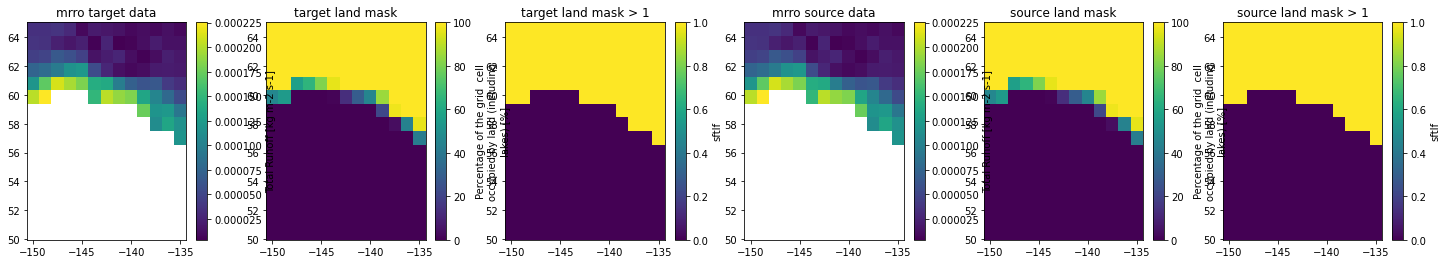

GFDL-ESM4


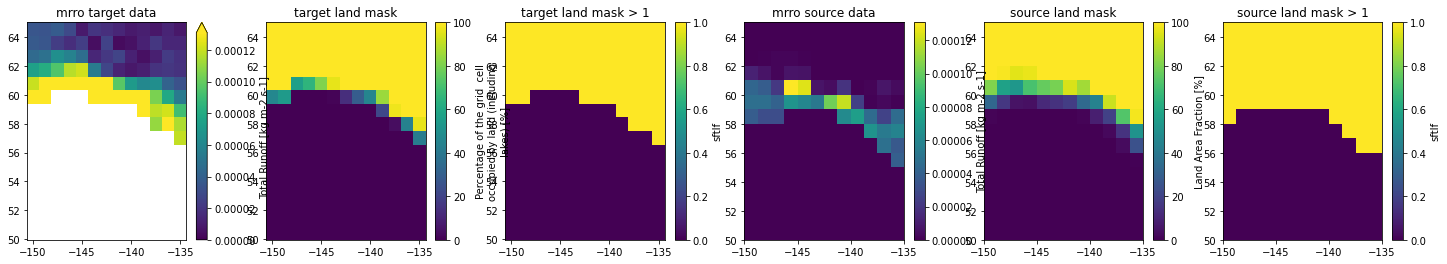

TaiESM1


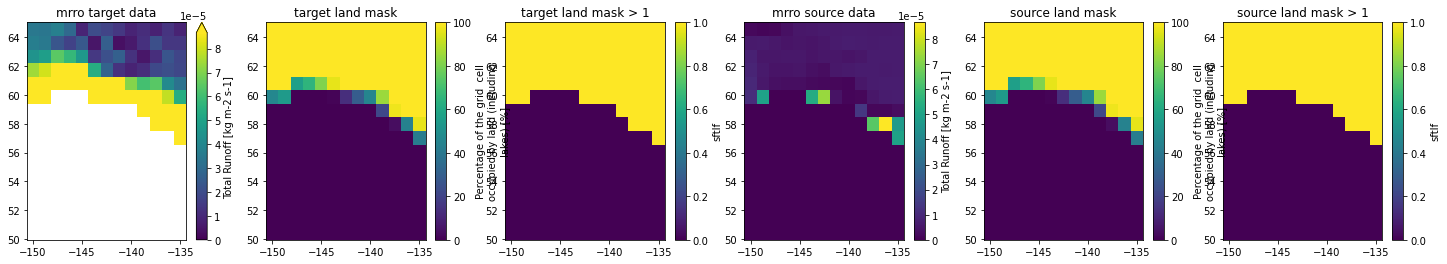

NorESM2-MM


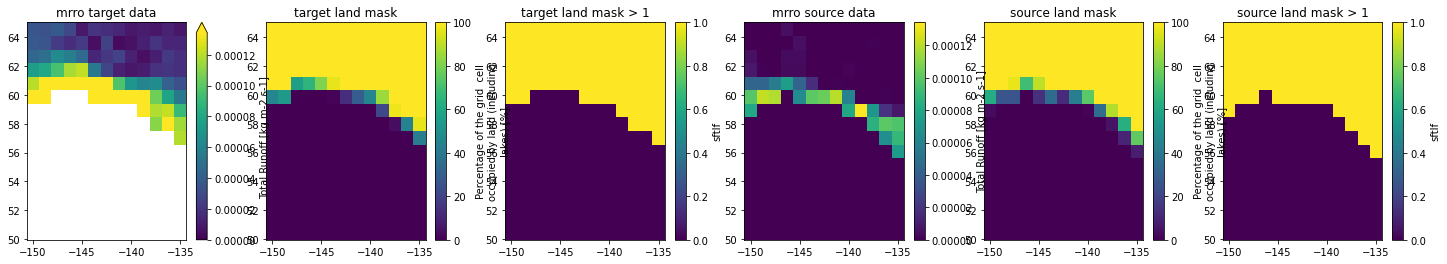

CNRM-CM6-1-HR


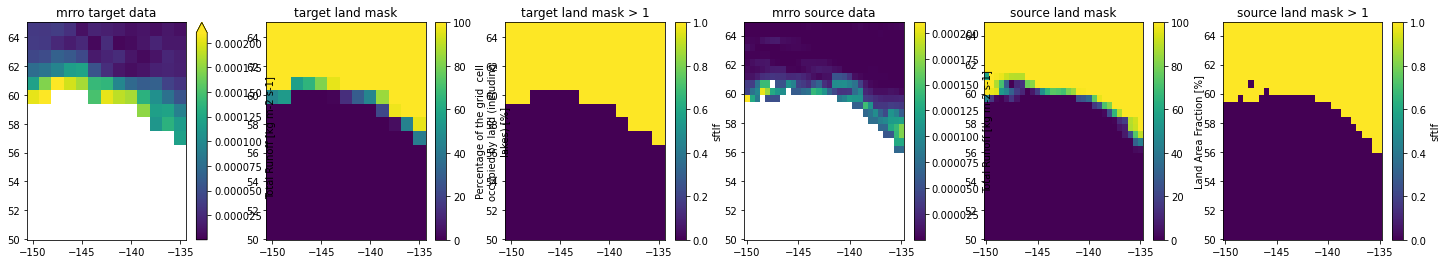

EC-Earth3-Veg


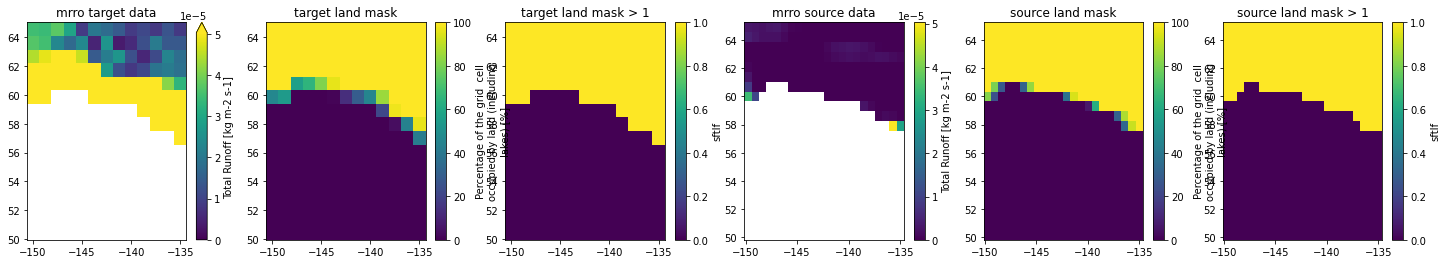

MIROC6


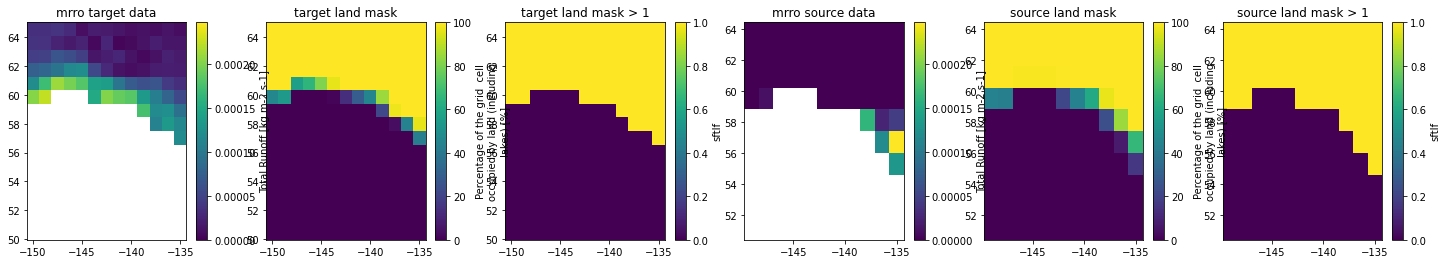

MPI-ESM1-2-LR


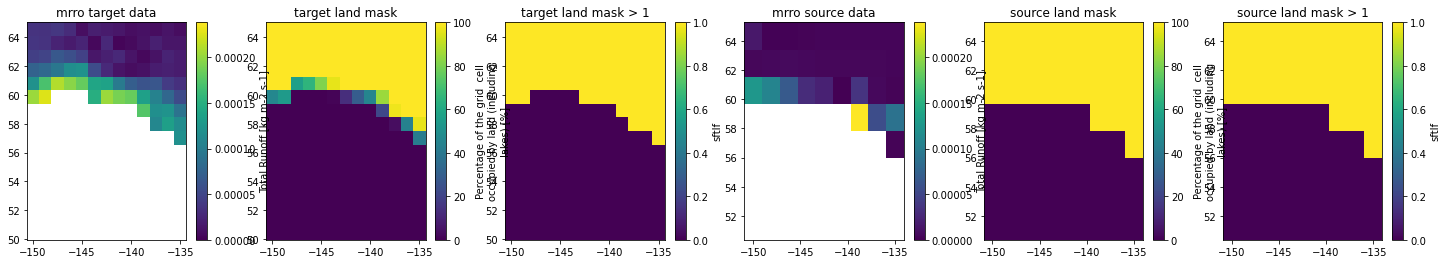

In [58]:
# define CESM2-WACCM target grid dataset and land mask
target_ds = load_ds(model_mrro_landmask_dict['CESM2-WACCM']['mrro'])
target_land_mask = load_ds(model_mrro_landmask_dict['CESM2-WACCM']['sftlf'], time=False)

# for each model, just plot source dataset and land mask with threshold
for model in model_mrro_landmask_dict.keys():
    print(model)
    src_ds = load_ds(model_mrro_landmask_dict[model]["mrro"])
    src_land_mask = load_ds(model_mrro_landmask_dict[model]["sftlf"], time=False)
    plot_data_and_land_masks(target_ds, target_land_mask, src_ds, src_land_mask, 1, "mrro", lat_slice, lon_slice)

CESM2-WACCM:


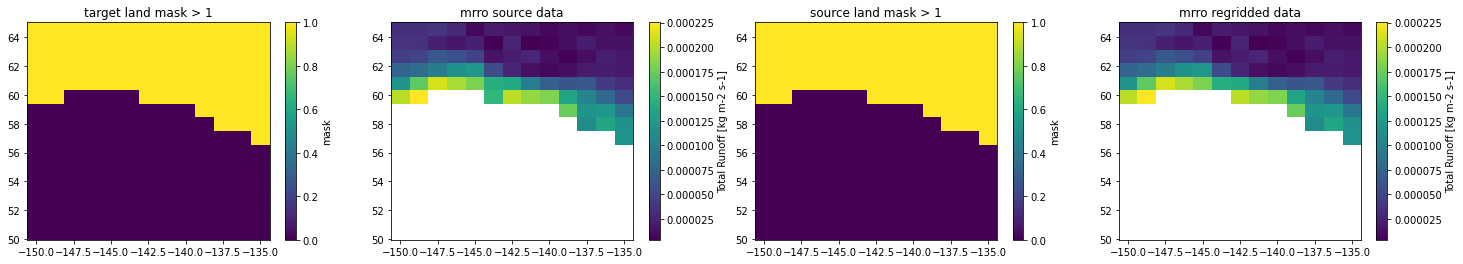

GFDL-ESM4:


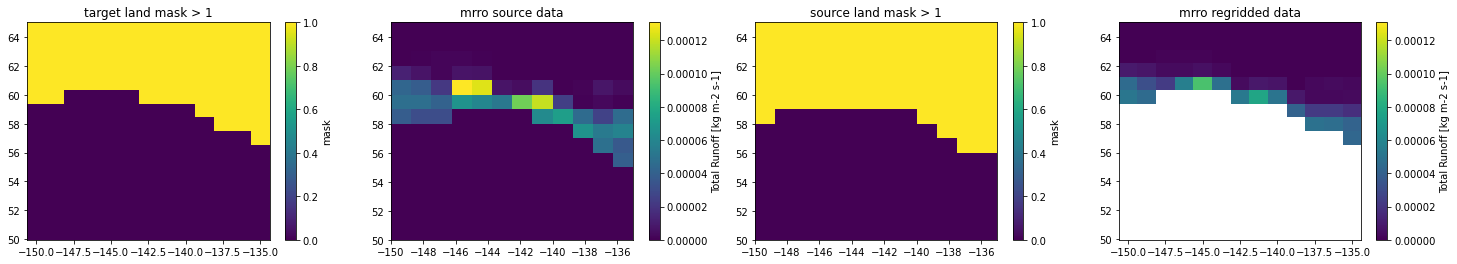

TaiESM1:


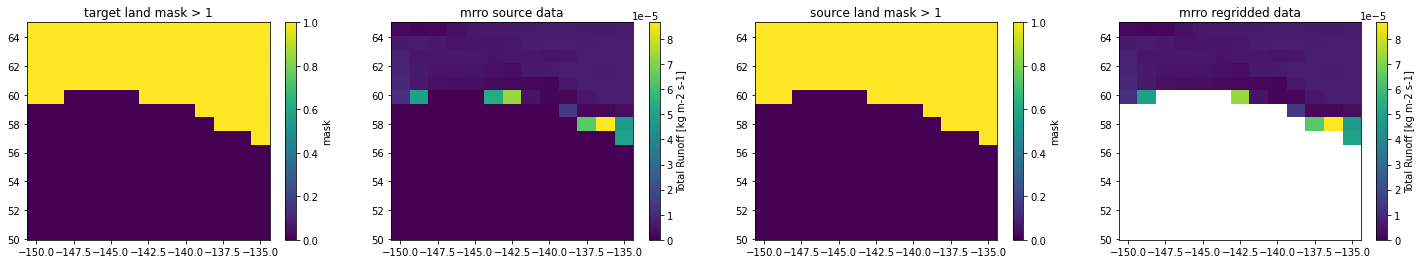

NorESM2-MM:


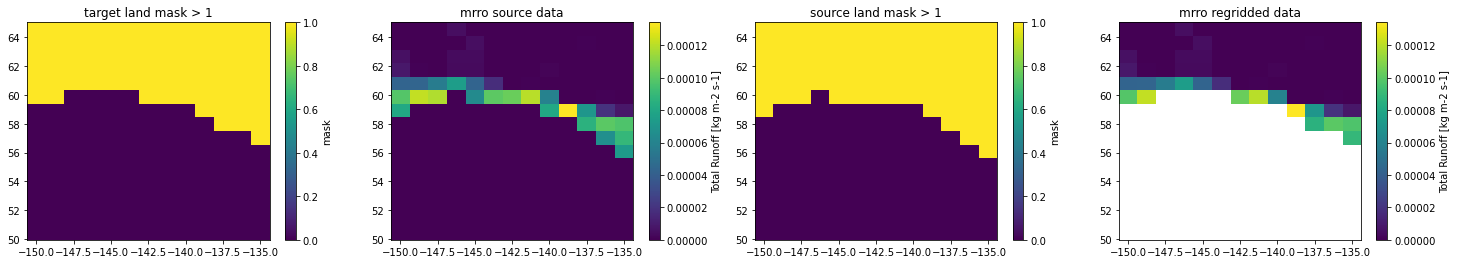

CNRM-CM6-1-HR:


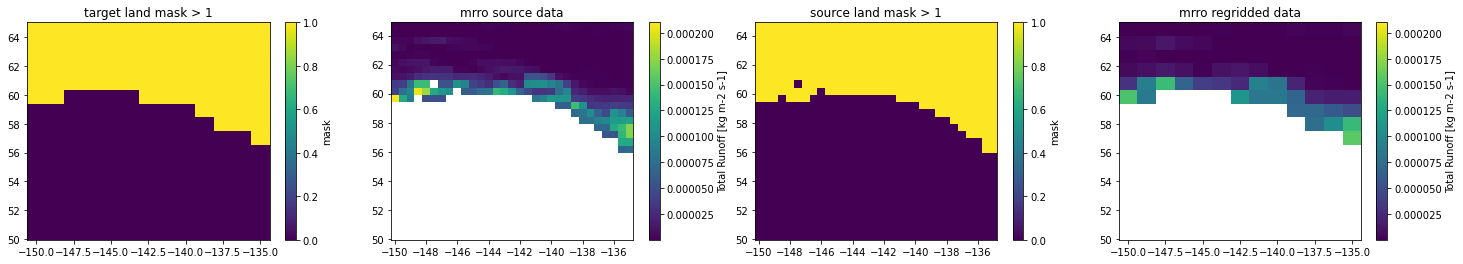

EC-Earth3-Veg:


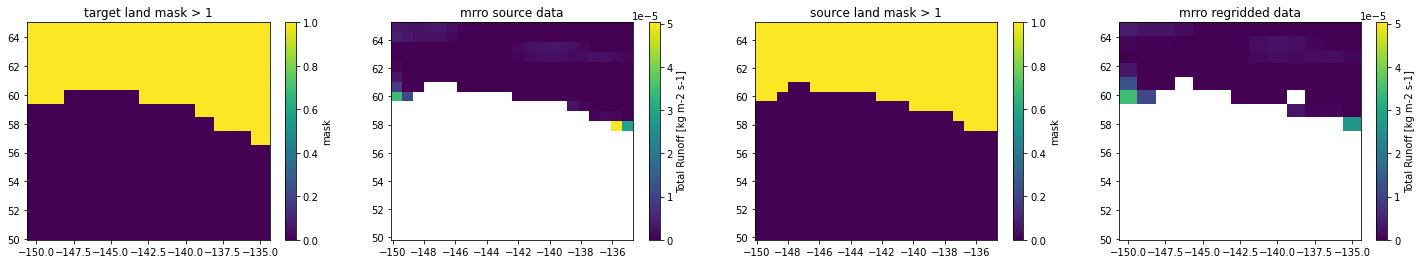

MIROC6:


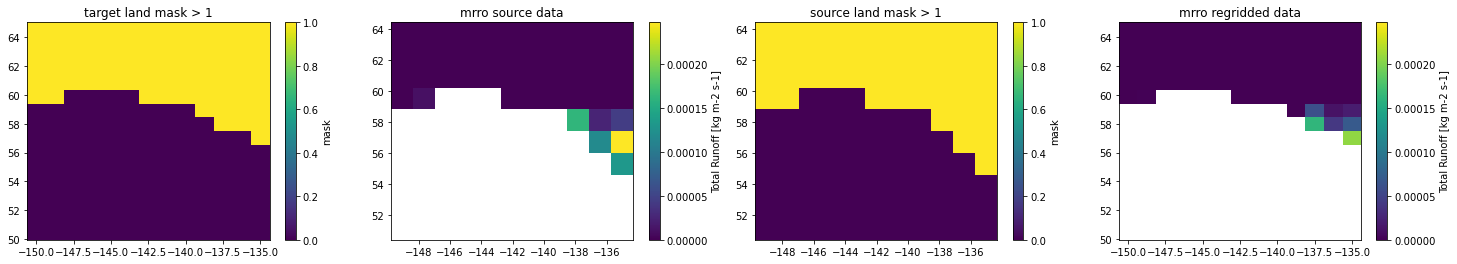

MPI-ESM1-2-LR:


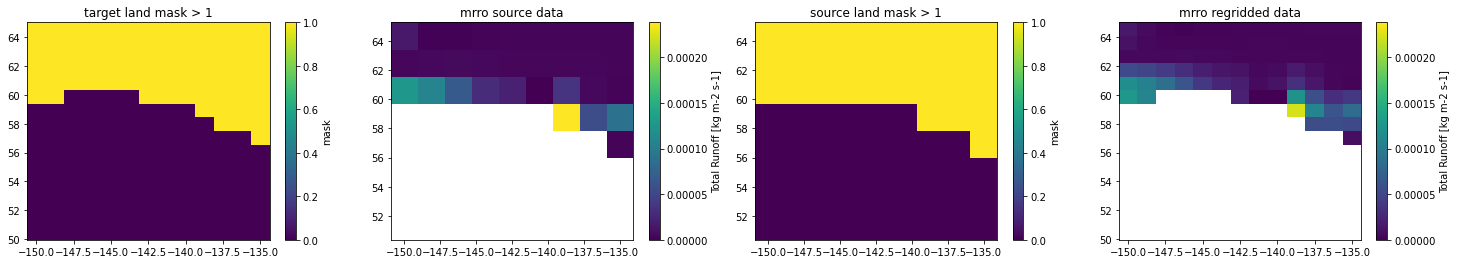

In [59]:
# define CESM2-WACCM target grid dataset and land mask
target_ds = load_ds(model_mrro_landmask_dict['CESM2-WACCM']['mrro'])
target_land_mask = load_ds(model_mrro_landmask_dict['CESM2-WACCM']['sftlf'], time=False)

# for each model, define source dataset and land mask, then regrid and plot
for model in model_mrro_landmask_dict.keys():
    src_ds = load_ds(model_mrro_landmask_dict[model]["mrro"])
    src_land_mask = load_ds(model_mrro_landmask_dict[model]["sftlf"], time=False)
    print(f"{model}:")
    regrid_landmask_and_plot(target_ds, target_land_mask, src_ds, src_land_mask, 1, "mrro", lat_slice, lon_slice)